In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import random 
import tensorflow as tf
import cv2
from segmentation_models.metrics import iou_score
from segmentation_models import Unet
import segmentation_models as sm
from keras.preprocessing.image import ImageDataGenerator
import skimage.transform as trans
sm.set_framework('tf.keras')
sm.framework()


Segmentation Models: using `keras` framework.


'tf.keras'

In [3]:
!pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
w,h = 256,256
batch_size = 16
BACKBONE = "resnet34"
preprocess_input = sm.get_preprocessing(BACKBONE)

In [6]:
path = "/content/drive/MyDrive/Br35H-Mask-RCNN/"

In [7]:
import glob

In [8]:
# load images in file train 
train_images = glob.glob(path + "TRAIN/" + "*.jpg")
train_mask = glob.glob(path + "TRAIN/" + "*.png")
#load images in file val
val_images = glob.glob(path + "VAL/" + "*.jpg")
val_mask = glob.glob(path + "VAL/" + "*.png")

In [9]:
print(train_images[0])
print(train_mask[0])

/content/drive/MyDrive/Br35H-Mask-RCNN/TRAIN/y247.jpg
/content/drive/MyDrive/Br35H-Mask-RCNN/TRAIN/y7.png


In [10]:
def read_image(image_path):
  image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
  image = image / 255
  image = trans.resize(image,(256,256,3))
  image = preprocess_input(image)
  return image
def read_mask(image_path):
  image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
  image = image /255
  image = trans.resize(image,(256,256,3))
  image[image != 0] = 1
  return image

In [11]:
x_train = []
for item in train_images:
  x_train.append(read_image(item))
y_train = []
for item in train_images:
  y_train.append(read_mask(item.replace('.jpg','.png')))
x_val = []
for item in val_images:
  x_val.append(read_image(item))
y_val = []
for item in val_images:
  y_val.append(read_mask(item.replace('.jpg','.png')))



In [12]:
x_train = np.array(x_train).astype('float32')

y_train = np.array(y_train).astype('float32')

x_val = np.array(x_val).astype('float32')

y_val = np.array(y_val).astype('float32')

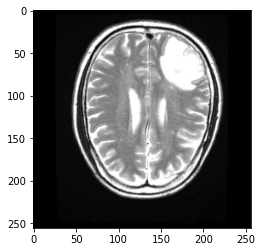

In [13]:
plt.imshow(x_train[0])
plt.show()

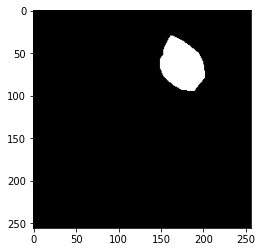

In [14]:
plt.imshow(y_train[0])
plt.show()

In [15]:
image_datagen = ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

image_datagen.fit(x_train,augment=True, seed=42)
mask_datagen.fit(y_train,augment=True, seed=42)


x_datagen = image_datagen.flow(x_train,batch_size=32,shuffle=False,seed=42)
y_datagen = image_datagen.flow(y_train,batch_size=32,shuffle=False,seed=42)


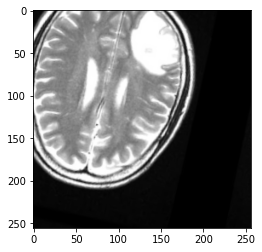

In [16]:
plt.imshow(x_datagen[0][0])
plt.show()

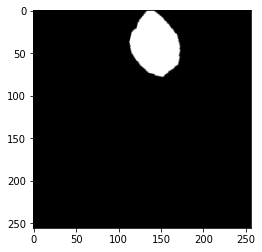

In [17]:
plt.imshow(y_datagen[0][0])
plt.show()

In [18]:
input_datagen = zip(x_datagen,y_datagen)

In [19]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
loss1 = sm.losses.categorical_focal_dice_loss

In [20]:
model = Unet(BACKBONE,encoder_weights='imagenet',classes=1,activation='sigmoid',input_shape=(w,h,3),encoder_freeze=True)


85521592/85521592 [==============================] - 3s 0us/step


In [21]:
from segmentation_models import metrics
model.compile(optimizer=opt,loss=loss1,metrics=[iou_score])

In [22]:
history = model.fit(input_datagen,epochs=100,validation_data=(x_val,y_val),validation_steps=1, steps_per_epoch=64)

Epoch 1/100
64/64 [==============================] - 90s 1s/step - loss: 0.6741 - iou_score: 0.2031 - val_loss: 0.8936 - val_iou_score: 0.0606
Epoch 2/100
64/64 [==============================] - 64s 1s/step - loss: 0.2595 - iou_score: 0.6012 - val_loss: 1.0627 - val_iou_score: 0.0058
Epoch 3/100
64/64 [==============================] - 59s 926ms/step - loss: 0.1706 - iou_score: 0.7207 - val_loss: 1.0559 - val_iou_score: 0.0071
Epoch 4/100
64/64 [==============================] - 61s 956ms/step - loss: 0.1493 - iou_score: 0.7526 - val_loss: 1.0892 - val_iou_score: 0.0011
Epoch 5/100
64/64 [==============================] - 59s 930ms/step - loss: 0.1320 - iou_score: 0.7784 - val_loss: 0.9803 - val_iou_score: 0.0496
Epoch 6/100
64/64 [==============================] - 59s 922ms/step - loss: 0.1210 - iou_score: 0.7954 - val_loss: 1.0781 - val_iou_score: 0.0108
Epoch 7/100
64/64 [==============================] - 60s 950ms/step - loss: 0.1099 - iou_score: 0.8126 - val_loss: 0.9133 - val_io

In [23]:
model.save("point.hdf5")

In [24]:
iou_score = history.history['iou_score']
val_iou_score = history.history['val_iou_score']

In [25]:
loss = history.history['loss']
val_loss = history.history['val_loss']

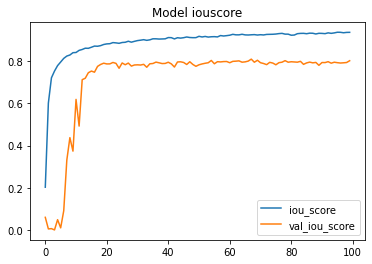

In [26]:
plt.plot(iou_score)
plt.plot(val_iou_score)
plt.title("Model iouscore")
plt.legend(['iou_score','val_iou_score'])
plt.show()

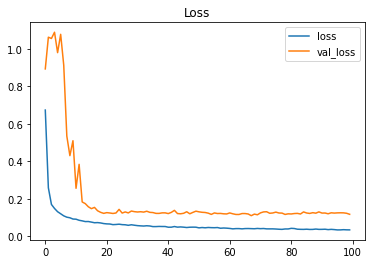

In [27]:
plt.plot(loss)
plt.plot(val_loss)
plt.title("Loss")
plt.legend(['loss','val_loss'])
plt.show()